In [52]:
# imports
%matplotlib inline
import numpy as np
import pandas as pd
import datetime
import time
import xgboost as xgb
import seaborn as sns
import geopandas as gp
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

first_datetime = datetime.datetime.strptime('2018-01-01 00:00:00', '%Y-%m-%d %H:%M:%S')
last_datetime = datetime.datetime.strptime('2018-07-01 00:00:00', '%Y-%m-%d %H:%M:%S')
train_valid_split_datetime = datetime.datetime.strptime('2018-06-01 00:00:00', '%Y-%m-%d %H:%M:%S')
print('first_datetime:', first_datetime)
print('last_datetime:', last_datetime)
print('train_valid_split_datetime:', train_valid_split_datetime)

first_datetime: 2018-01-01 00:00:00
last_datetime: 2018-07-01 00:00:00
train_valid_split_datetime: 2018-06-01 00:00:00


In [2]:
taxi_zone_lookup = pd.read_csv('nyc-tlc/misc/taxi _zone_lookup.csv')
print('taxi_zone_lookup:', taxi_zone_lookup.shape)
print(taxi_zone_lookup.head())
manhattan_location_ids = taxi_zone_lookup[taxi_zone_lookup['Borough']=='Manhattan']['LocationID'].values
print('manhattan_location_ids:', manhattan_location_ids.shape)
print(manhattan_location_ids)

taxi_zone_lookup: (265, 4)
   LocationID        Borough                     Zone service_zone
0           1            EWR           Newark Airport          EWR
1           2         Queens              Jamaica Bay    Boro Zone
2           3          Bronx  Allerton/Pelham Gardens    Boro Zone
3           4      Manhattan            Alphabet City  Yellow Zone
4           5  Staten Island            Arden Heights    Boro Zone
manhattan_location_ids: (69,)
[  4  12  13  24  41  42  43  45  48  50  68  74  75  79  87  88  90 100
 103 104 105 107 113 114 116 120 125 127 128 137 140 141 142 143 144 148
 151 152 153 158 161 162 163 164 166 170 186 194 202 209 211 224 229 230
 231 232 233 234 236 237 238 239 243 244 246 249 261 262 263]


In [3]:
def get_5min_id(x):
    return (x-first_datetime).total_seconds()//(5*60)

def get_15min_id(x):
    return (x-first_datetime).total_seconds()//(15*60)

def get_30min_id(x):
    return (x-first_datetime).total_seconds()//(30*60)

In [4]:
train_valid_split_5min_id = get_5min_id(train_valid_split_datetime)
train_valid_split_15min_id = get_15min_id(train_valid_split_datetime)
train_valid_split_30min_id = get_30min_id(train_valid_split_datetime)
print('train_valid_split_5min_id:', train_valid_split_5min_id)
print('train_valid_split_15min_id:', train_valid_split_15min_id)
print('train_valid_split_30min_id:', train_valid_split_30min_id)

train_valid_split_5min_id: 43488.0
train_valid_split_15min_id: 14496.0
train_valid_split_30min_id: 7248.0


In [ ]:
start = time.time()
demo = False
if demo:
    sample = pd.read_csv('nyc-tlc/trip data/sample.csv')
else:
    sample_1 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-01.csv')
    print('read_csv 2018-01:', time.time()-start)
    sample_2 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-02.csv')
    print('read_csv 2018-02:', time.time()-start)
    sample_3 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-03.csv')
    print('read_csv 2018-03:', time.time()-start)
    sample_4 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-04.csv')
    print('read_csv 2018-04:', time.time()-start)
    sample_5 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-05.csv')
    print('read_csv 2018-05:', time.time()-start)
    sample_6 = pd.read_csv('nyc-tlc/trip data/yellow_tripdata_2018-06.csv')
    print('read_csv 2018-06:', time.time()-start)
    sample = pd.concat([sample_1, sample_2, sample_3, sample_4, sample_5, sample_6], axis=0)
    print('concat:', time.time()-start)
print('sample:', sample.shape)
#print(sample.head())
sample_manhattan = sample[sample['PULocationID'].isin(manhattan_location_ids)].copy()
print('sample_manhattan:', sample_manhattan.shape)
#print(sample_manhattan.head())
print('filter PULocationID:', time.time()-start)

sample_manhattan['store_and_fwd_flag'] = sample_manhattan['store_and_fwd_flag'].map(lambda x: x=='N' and 0 or 1)
print('store_and_fwd_flag:', time.time()-start)
sample_manhattan['tpep_pickup_datetime'] = pd.to_datetime(sample_manhattan['tpep_pickup_datetime'])
print('tpep_pickup_datetime:', time.time()-start)
sample_manhattan['tpep_pickup_date'] = sample_manhattan['tpep_pickup_datetime'].dt.date
print('tpep_pickup_date:', time.time()-start)
sample_manhattan['tpep_dropoff_datetime'] = pd.to_datetime(sample_manhattan['tpep_dropoff_datetime'])
print('tpep_dropoff_datetime:', time.time()-start)
sample_manhattan['tpep_dropoff_date'] = sample_manhattan['tpep_dropoff_datetime'].dt.date
print('tpep_dropoff_date:', time.time()-start)
sample_manhattan['trip_duration'] = sample_manhattan['tpep_dropoff_datetime']-sample_manhattan['tpep_pickup_datetime']
print('trip_duration:', time.time()-start)
sample_manhattan['trip_duration'] = sample_manhattan['trip_duration'].map(lambda x: x.total_seconds())
sample_manhattan['trip_speed'] = sample_manhattan['trip_distance']/sample_manhattan['trip_duration']
print('trip_speed:', time.time()-start)
sample_manhattan['tpep_pickup_year'] = sample_manhattan['tpep_pickup_datetime'].map(lambda x: x.year)
print('tpep_pickup_year:', time.time()-start)
sample_manhattan['tpep_pickup_month'] = sample_manhattan['tpep_pickup_datetime'].map(lambda x: x.month)
print('tpep_pickup_month:', time.time()-start)
sample_manhattan['tpep_pickup_day'] = sample_manhattan['tpep_pickup_datetime'].map(lambda x: x.day)
print('tpep_pickup_day:', time.time()-start)
sample_manhattan['tpep_pickup_hour'] = sample_manhattan['tpep_pickup_datetime'].map(lambda x: x.hour)
print('tpep_pickup_hour:', time.time()-start)
sample_manhattan['tpep_pickup_weekday'] = sample_manhattan['tpep_pickup_datetime'].map(lambda x: x.weekday())
print('tpep_pickup_weekday:', time.time()-start)
sample_manhattan['is_weekend'] = sample_manhattan['tpep_pickup_weekday'].map(lambda x: x >= 5 and 1 or 0)
print('is_weekend:', time.time()-start)
sample_manhattan['is_morning_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 7 <= x <= 9 and 1 or 0)
print('is_morning_peak:', time.time()-start)
sample_manhattan['is_evening_peak'] = sample_manhattan['tpep_pickup_hour'].map(lambda x: 17 <= x <= 19 and 1 or 0)
print('is_evening_peak:', time.time()-start)

VendorID_dummy = pd.get_dummies(sample_manhattan['VendorID'], prefix='vi', prefix_sep='_')
print('VendorID_dummy:', time.time()-start)
store_and_fwd_flag_dummy = pd.get_dummies(sample_manhattan['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
print('store_and_fwd_flag_dummy:', time.time()-start)
passenger_count_dummy = pd.get_dummies(sample_manhattan['passenger_count'], prefix='pc', prefix_sep='_')
print('passenger_count_dummy:', time.time()-start)
RatecodeID_dummy = pd.get_dummies(sample_manhattan['RatecodeID'], prefix='rc', prefix_sep='_')
print('RatecodeID_dummy:', time.time()-start)
payment_type_dummy = pd.get_dummies(sample_manhattan['payment_type'], prefix='pt', prefix_sep='_')
print('payment_type_dummy:', time.time()-start)

sample_manhattan = pd.concat([sample_manhattan, VendorID_dummy, store_and_fwd_flag_dummy, passenger_count_dummy, RatecodeID_dummy, payment_type_dummy], axis=1)
print('concat:', time.time()-start)

sample_manhattan['tpep_pickup_5min_id'] = sample_manhattan['tpep_pickup_datetime'].map(lambda x: get_5min_id(x))
print('tpep_pickup_5min_id:', time.time()-start)
sample_manhattan['tpep_pickup_15min_id'] = sample_manhattan['tpep_pickup_datetime'].map(lambda x: get_15min_id(x))
print('tpep_pickup_15min_id:', time.time()-start)
sample_manhattan['tpep_pickup_30min_id'] = sample_manhattan['tpep_pickup_datetime'].map(lambda x: get_30min_id(x))
print('tpep_pickup_30min_id:', time.time()-start)

sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] > 0]
print('filter trip_duration:', time.time()-start)
sample_manhattan = sample_manhattan[sample_manhattan['total_amount'] > 0]
print('filter total_amount:', time.time()-start)
sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] >= first_datetime]
print('filter tpep_pickup_datetime first_datetime:', time.time()-start)
sample_manhattan = sample_manhattan[sample_manhattan['tpep_pickup_datetime'] < last_datetime]
print('filter tpep_pickup_datetime last_datetime:', time.time()-start)

m = np.mean(sample_manhattan['trip_duration'])
s = np.std(sample_manhattan['trip_duration'])
sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] <= m + 2*s]
sample_manhattan = sample_manhattan[sample_manhattan['trip_duration'] >= m - 2*s]
print('filter trip_duration:', time.time()-start)

#sample_manhattan.drop(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'tpep_pickup_date', 'tpep_dropoff_date'], axis=1, inplace=True)

read_csv 2018-01: 26.49527096748352
read_csv 2018-02: 50.49302792549133
read_csv 2018-03: 78.77131819725037
read_csv 2018-04: 105.80626010894775
read_csv 2018-05: 131.29161405563354
read_csv 2018-06: 154.7310438156128
concat: 224.9858467578888
sample: (53925735, 17)
sample_manhattan: (48959840, 17)
filter PULocationID: 561.0321230888367
store_and_fwd_flag: 590.6455810070038
tpep_pickup_datetime: 604.4092619419098
tpep_pickup_date: 619.8279581069946
tpep_dropoff_datetime: 633.5812089443207
tpep_dropoff_date: 655.4375030994415
trip_duration: 659.6398260593414
trip_speed: 1266.545709848404
tpep_pickup_year: 1639.3908891677856
tpep_pickup_month: 1917.8792190551758
tpep_pickup_day: 2184.447203874588
tpep_pickup_hour: 2432.46954202652
tpep_pickup_weekday: 2711.038460969925


In [43]:
sample_manhattan.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,tpep_pickup_date,tpep_dropoff_date,trip_duration,trip_speed,tpep_pickup_year,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,vi_1,vi_2,sf_1,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,rc_1,rc_2,rc_3,rc_4,rc_5,rc_6,pt_1,pt_2,pt_3,pt_4,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.500,1,1,41,24,2,4.500,0.500,0.500,0.000,0.000,0.300,5.800,2018-01-01,2018-01-01,198.000,0.003,2018,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,4.000,1.000,0.000
1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.700,1,1,239,140,2,14.000,0.500,0.500,0.000,0.000,0.300,15.300,2018-01-01,2018-01-01,1090.000,0.002,2018,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,8.000,2.000,1.000
2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.800,1,1,262,141,1,6.000,0.500,0.500,1.000,0.000,0.300,8.300,2018-01-01,2018-01-01,355.000,0.002,2018,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1.000,0.000,0.000
3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.200,1,1,140,257,2,33.500,0.500,0.500,0.000,0.000,0.300,34.800,2018-01-01,2018-01-01,1949.000,0.005,2018,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,4.000,1.000,0.000
4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.500,1,1,246,239,1,12.500,0.500,0.500,2.750,0.000,0.300,16.550,2018-01-01,2018-01-01,1068.000,0.002,2018,1,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1.000,0.000,0.000


In [45]:
sample_manhattan.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,trip_duration,trip_speed,tpep_pickup_year,tpep_pickup_month,tpep_pickup_day,tpep_pickup_hour,tpep_pickup_weekday,is_weekend,is_morning_peak,is_evening_peak,vi_1,vi_2,sf_1,pc_0,pc_1,pc_2,pc_3,pc_4,pc_5,pc_6,rc_1,rc_2,rc_3,rc_4,rc_5,rc_6,pt_1,pt_2,pt_3,pt_4,tpep_pickup_5min_id,tpep_pickup_15min_id,tpep_pickup_30min_id
count,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000,87276.000
mean,1.578,1.696,3.050,1.038,1.000,154.736,151.021,1.411,12.624,0.390,0.497,1.582,0.209,0.300,15.609,752.558,0.004,2018.000,1.000,1.000,3.224,0.000,0.000,0.112,0.000,0.422,0.578,1.000,0.005,0.655,0.183,0.054,0.030,0.046,0.027,0.983,0.008,0.003,0.000,0.006,0.000,0.600,0.391,0.007,0.002,44.149,14.382,6.940
std,0.494,1.266,3.232,0.336,0.000,69.509,73.769,0.517,10.454,0.208,0.041,2.619,1.324,0.004,12.359,553.215,0.022,0.000,0.000,0.003,3.061,0.003,0.000,0.316,0.008,0.494,0.494,0.000,0.070,0.475,0.387,0.226,0.169,0.210,0.162,0.128,0.087,0.056,0.020,0.075,0.007,0.490,0.488,0.085,0.042,36.892,12.297,6.146
min,1.000,0.000,0.000,1.000,1.000,4.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.300,1.000,0.000,2018.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,1.000,1.000,1.000,1.000,1.000,100.000,87.000,1.000,6.000,0.500,0.500,0.000,0.000,0.300,8.160,336.000,0.003,2018.000,1.000,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,16.000,5.000,2.000
50%,2.000,1.000,1.910,1.000,1.000,158.000,148.000,1.000,9.500,0.500,0.500,1.000,0.000,0.300,11.800,610.000,0.003,2018.000,1.000,1.000,2.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,33.000,11.000,5.000
75%,2.000,2.000,3.900,1.000,1.000,230.000,230.000,2.000,15.500,0.500,0.500,2.260,0.000,0.300,18.800,1033.000,0.005,2018.000,1.000,1.000,5.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,60.000,20.000,10.000
max,2.000,6.000,49.200,6.000,1.000,263.000,265.000,4.000,350.000,1.000,0.500,191.700,25.500,0.300,375.800,9829.000,3.200,2018.000,1.000,2.000,23.000,1.000,0.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,292.000,97.000,48.000


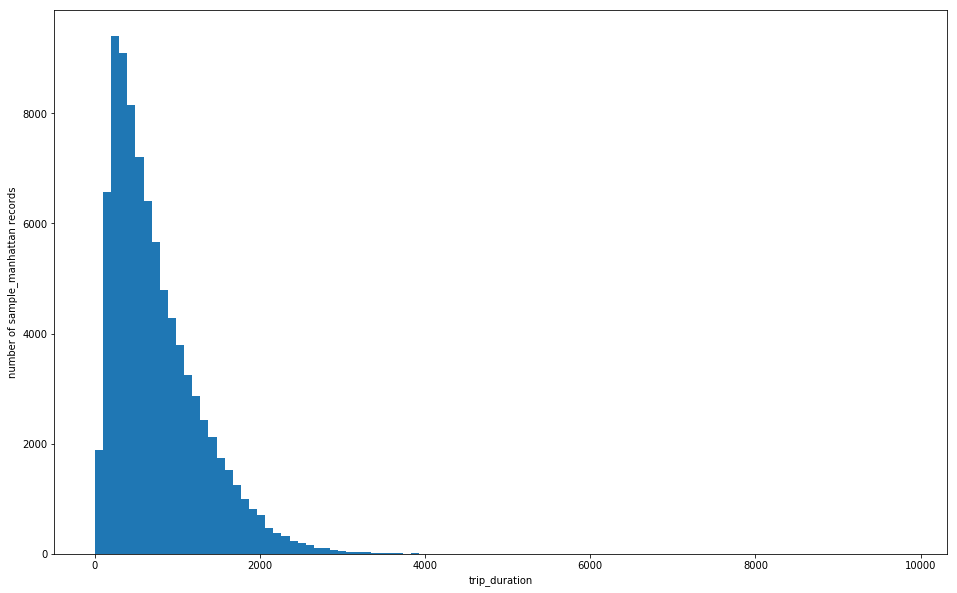

In [46]:
plt.hist(sample_manhattan['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of sample_manhattan records')
plt.show()

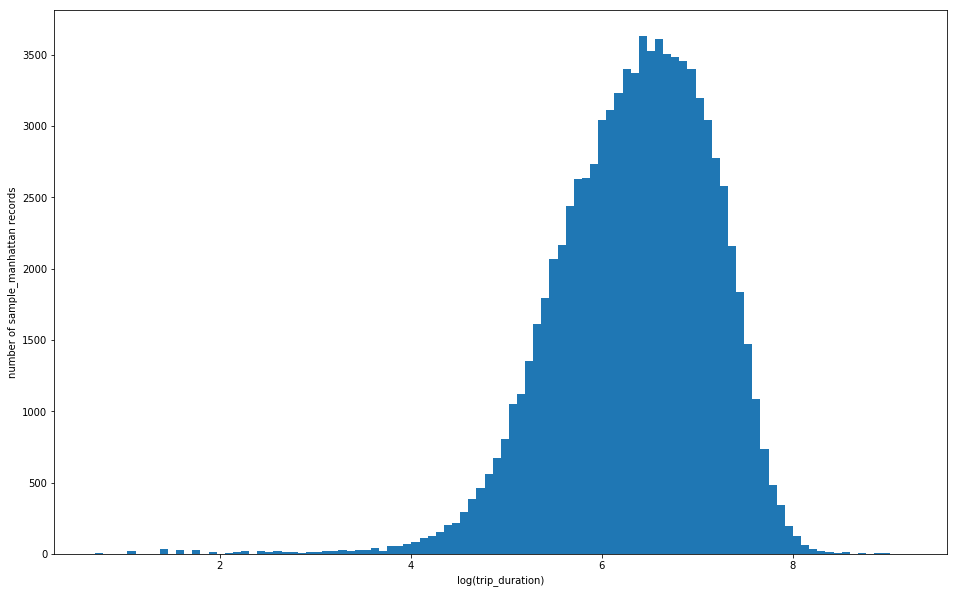

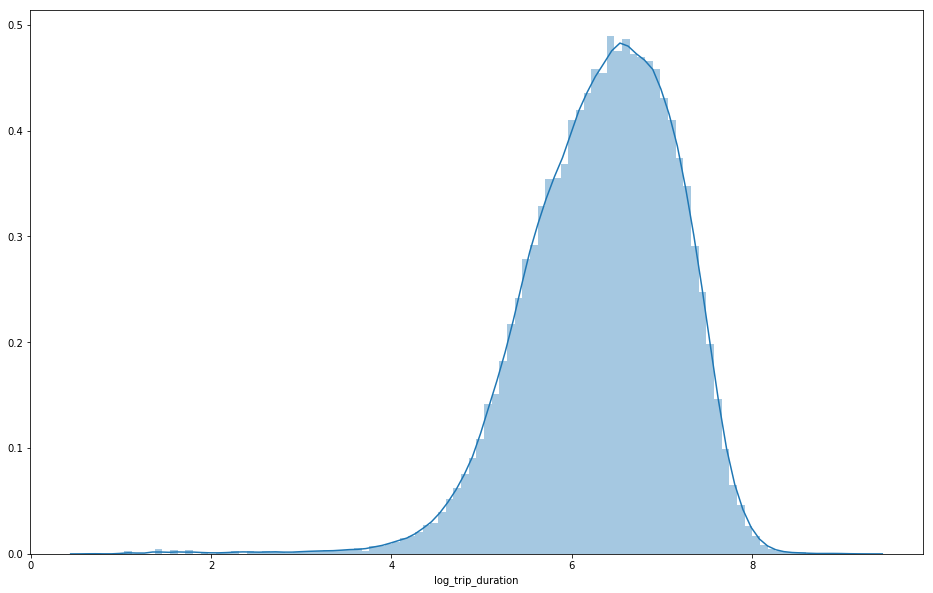

In [47]:
sample_manhattan['log_trip_duration'] = np.log(sample_manhattan['trip_duration'].values + 1)
plt.hist(sample_manhattan['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of sample_manhattan records')
plt.show()
sns.distplot(sample_manhattan["log_trip_duration"], bins =100)

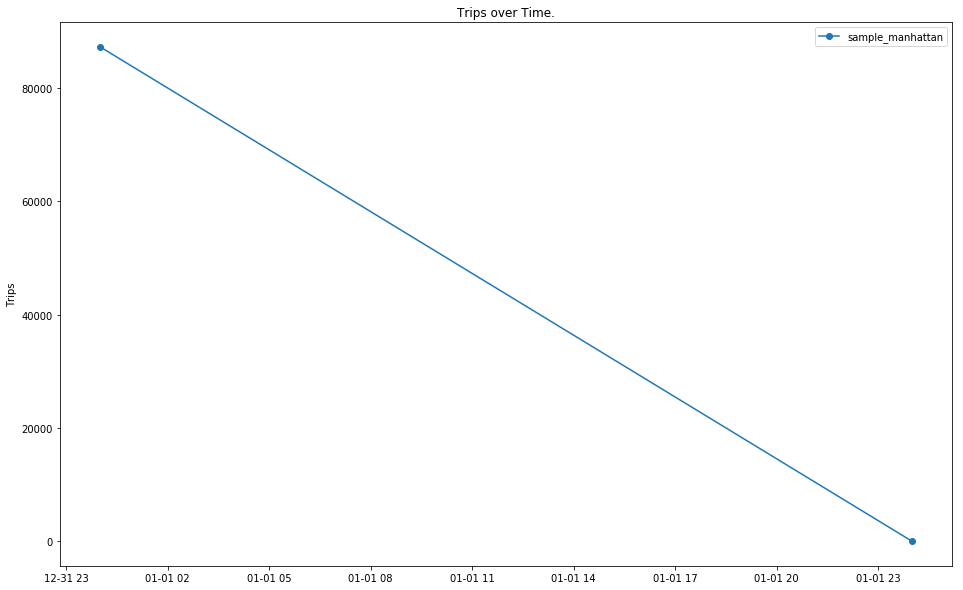

In [48]:
plt.plot(sample_manhattan.groupby('tpep_pickup_date').count()[['VendorID']], 'o-', label='sample_manhattan')
plt.title('Trips over Time.')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

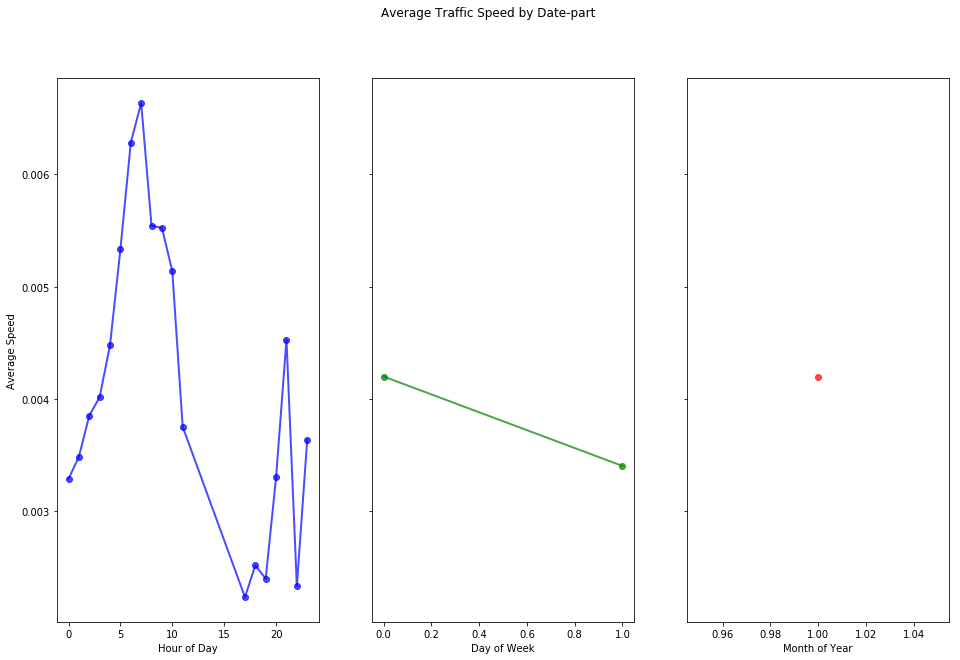

In [49]:
fig, ax = plt.subplots(ncols=3, sharey=True)
ax[0].plot(sample_manhattan.groupby('tpep_pickup_hour').mean()['trip_speed'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(sample_manhattan.groupby('tpep_pickup_weekday').mean()['trip_speed'], 'go-', lw=2, alpha=0.7)
ax[2].plot(sample_manhattan.groupby('tpep_pickup_month').mean()['trip_speed'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour of Day')
ax[1].set_xlabel('Day of Week')
ax[2].set_xlabel('Month of Year')
ax[0].set_ylabel('Average Speed')
fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

In [70]:
taxi_zones_shape = gp.GeoDataFrame.from_file('nyc-tlc/misc/taxi_zones/taxi_zones.shp')
taxi_zones_shape = taxi_zones_shape[taxi_zones_shape['borough'] == 'Manhattan']
#taxi_zones_shape['color'] = 'green'
taxi_zones_shape.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
3,4,0.044,0.000,Alphabet City,4,Manhattan,"POLYGON ((992073.4667968601 203714.0759887695,..."
11,12,0.037,0.000,Battery Park,12,Manhattan,"POLYGON ((979908.771901235 196066.5651661754, ..."
12,13,0.050,0.000,Battery Park City,13,Manhattan,"POLYGON ((980801.3095727563 201248.8694928288,..."
23,24,0.047,0.000,Bloomingdale,24,Manhattan,"POLYGON ((995453.1139255464 230274.2667761594,..."
40,41,0.053,0.000,Central Harlem,41,Manhattan,"POLYGON ((998716.9128961712 234240.3971749842,..."


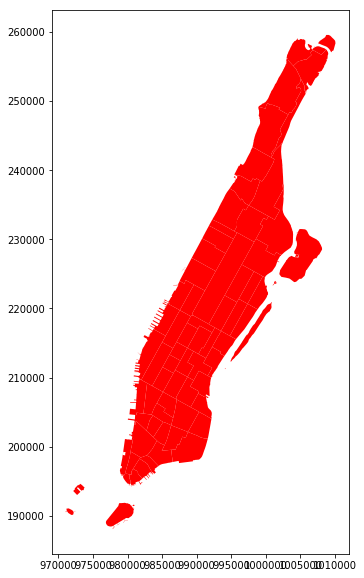

In [72]:
taxi_zones_shape.plot(color='red')

In [79]:
train_sample_5min_count = sample_manhattan[sample_manhattan['tpep_pickup_5min_id'] < train_valid_split_5min_id].groupby(['tpep_pickup_5min_id', 'PULocationID']).count()['VendorID']
print('train_sample_5min_count:', train_sample_5min_count.shape)
print(train_sample_5min_count.head())
valid_sample_5min_count = sample_manhattan[sample_manhattan['tpep_pickup_5min_id'] >= train_valid_split_5min_id].groupby(['tpep_pickup_5min_id', 'PULocationID']).count()['VendorID']
print('valid_sample_5min_count:', valid_sample_5min_count.shape)
print(valid_sample_5min_count.head())
print('valid_sample_5min_count:', type(valid_sample_5min_count))
print(valid_sample_5min_count[5760][4])

train_sample_5min_count: (307167,)
tpep_pickup_5min_id  PULocationID
0.000                4               3
                     13              4
                     24              2
                     41              3
                     42              3
Name: VendorID, dtype: int64
valid_sample_5min_count: (169459,)
tpep_pickup_5min_id  PULocationID
5760.000             4               14
                     13               4
                     24               2
                     41               7
                     42               2
Name: VendorID, dtype: int64


In [95]:
sample_manhattan_5min_count = sample_manhattan.groupby(['tpep_pickup_5min_id', 'PULocationID']).count()['VendorID']

def generate_features(data_X):
    start = time.time()
    ago_5min = []
    ago_1day_now = []
    ago_7day_now = []
    ago_14day_now = []
    ago_21day_now = []
    ago_28day_now = []
    for index,row in data_X.iterrows():
        #print('index:', index)
        #print('row:', row)
        try:
            ago_5min.append(sample_manhattan_5min_count[index[0]-1][index[1]])
        except:
            ago_5min.append(0)
        try:
            ago_1day_now.append(sample_manhattan_5min_count[index[0]-288][index[1]])
        except:
            ago_1day_now.append(0)
        try:
            ago_7day_now.append(sample_manhattan_5min_count[index[0]-288*7][index[1]])
        except:
            ago_7day_now.append(0)
        try:
            ago_14day_now.append(sample_manhattan_5min_count[index[0]-288*14][index[1]])
        except:
            ago_14day_now.append(0)
        try:
            ago_21day_now.append(sample_manhattan_5min_count[index[0]-288*21][index[1]])
        except:
            ago_21day_now.append(0)
        try:
            ago_28day_now.append(sample_manhattan_5min_count[index[0]-288*28][index[1]])
        except:
            ago_28day_now.append(0)
    data_X['5min_ago'] = np.array(ago_5min)
    data_X['1day_ago_now'] = np.array(ago_1day_now)
    data_X['7day_ago_now'] = np.array(ago_7day_now)
    data_X['14day_ago_now'] = np.array(ago_14day_now)
    data_X['21day_ago_now'] = np.array(ago_21day_now)
    data_X['28day_ago_now'] = np.array(ago_28day_now)
    print('data_X time:', time.time()-start)
    return data_X

train_X = pd.DataFrame(train_sample_5min_count)
train_X = generate_features(train_X)
print('train_X:', train_X.shape)
print(train_X.head())
valid_X = pd.DataFrame(valid_sample_5min_count)
valid_X = generate_features(valid_X)
print('valid_X:', valid_X.shape)
print(valid_X.head())
train_Y = train_sample_5min_count.values
print('train_Y:', len(train_Y))
valid_Y = valid_sample_5min_count.values
print('valid_Y:', len(valid_Y))

train_X time: 357.75938081741333
train_X: (307167, 7)
                                  VendorID  5min_ago  1day_ago_now  \
tpep_pickup_5min_id PULocationID                                     
0.000               4                    3         0             0   
                    13                   4         0             0   
                    24                   2         0             0   
                    41                   3         0             0   
                    42                   3         0             0   

                                  7day_ago_now  14day_ago_now  21day_ago_now  \
tpep_pickup_5min_id PULocationID                                               
0.000               4                        0              0              0   
                    13                       0              0              0   
                    24                       0              0              0   
                    41                       0         

In [103]:
def xgb_train_validate(train_X, train_Y, test_X, test_Y):
    xg_train = xgb.DMatrix(train_X.drop('VendorID', axis=1), label=train_Y)
    xg_test = xgb.DMatrix(test_X.drop('VendorID', axis=1), label=test_Y)
    # setup parameters for xgboost
    param = {}
    # scale weight of positive examples
    param['eta'] = 0.1  # default
    # param['eta'] = 0.02
    param['max_depth'] = 20  # default: 6
    param['silent'] = 1  # default
    param['nthread'] = 4  # default
    param['gamma'] = 1
    param['subsample'] = 0.9
    param['min_child_weight'] = 1
    param['colsample_bytree'] = 0.9
    param['lambda'] = 1
    param['booster'] = 'gbtree'
    param['eval_metric'] = 'mae'

    watchlist = [(xg_train, 'train'), (xg_test, 'test')]
    # num_round = 5
    num_round = 400

    # param['objective'] = 'reg:linear'
    param['objective'] = 'reg:gamma'
    bst = xgb.train(param, xg_train, num_round, watchlist)

    # xgb.plot_tree(bst)
    # plt.savefig('xgboost_tree.png')
    # xgb.plot_importance(bst)
    # plt.savefig('xgboost_importance.png')
    imp = bst.get_fscore()
    print(sorted(imp.items(), key=lambda d: d[1], reverse=True))

In [104]:
xgb_train_validate(train_X, train_Y, valid_X, valid_Y)

[0]	train-mae:15.7128	test-mae:16.9487
[1]	train-mae:15.6607	test-mae:16.8964
[2]	train-mae:15.6042	test-mae:16.8395
[3]	train-mae:15.5428	test-mae:16.7775
[4]	train-mae:15.4764	test-mae:16.7104
[5]	train-mae:15.4045	test-mae:16.6376
[6]	train-mae:15.3267	test-mae:16.5588
[7]	train-mae:15.243	test-mae:16.4739
[8]	train-mae:15.1545	test-mae:16.3839
[9]	train-mae:15.0625	test-mae:16.29
[10]	train-mae:14.9643	test-mae:16.1906
[11]	train-mae:14.8627	test-mae:16.0861
[12]	train-mae:14.7547	test-mae:15.9747
[13]	train-mae:14.6387	test-mae:15.855
[14]	train-mae:14.5139	test-mae:15.7261
[15]	train-mae:14.38	test-mae:15.5876
[16]	train-mae:14.2374	test-mae:15.4396
[17]	train-mae:14.0861	test-mae:15.2818
[18]	train-mae:13.9259	test-mae:15.1146
[19]	train-mae:13.7562	test-mae:14.9365
[20]	train-mae:13.5765	test-mae:14.748
[21]	train-mae:13.3871	test-mae:14.5485
[22]	train-mae:13.1876	test-mae:14.3381
[23]	train-mae:12.9808	test-mae:14.1165
[24]	train-mae:12.7613	test-mae:13.8829
[25]	train-mae:12

[204]	train-mae:3.55259	test-mae:3.63189
[205]	train-mae:3.55252	test-mae:3.63202
[206]	train-mae:3.55255	test-mae:3.63209
[207]	train-mae:3.55245	test-mae:3.63212
[208]	train-mae:3.55224	test-mae:3.63221
[209]	train-mae:3.5521	test-mae:3.63231
[210]	train-mae:3.5519	test-mae:3.63263
[211]	train-mae:3.55186	test-mae:3.63264
[212]	train-mae:3.55187	test-mae:3.63277
[213]	train-mae:3.55179	test-mae:3.63263
[214]	train-mae:3.55178	test-mae:3.63262
[215]	train-mae:3.5517	test-mae:3.63267
[216]	train-mae:3.55156	test-mae:3.6326
[217]	train-mae:3.55151	test-mae:3.63257
[218]	train-mae:3.55152	test-mae:3.63261
[219]	train-mae:3.55137	test-mae:3.63251
[220]	train-mae:3.55139	test-mae:3.63255
[221]	train-mae:3.55139	test-mae:3.63259
[222]	train-mae:3.5514	test-mae:3.63261
[223]	train-mae:3.55117	test-mae:3.63263
[224]	train-mae:3.55116	test-mae:3.63262
[225]	train-mae:3.55117	test-mae:3.63267
[226]	train-mae:3.55113	test-mae:3.63272
[227]	train-mae:3.55105	test-mae:3.63253
[228]	train-mae:3.551

In [105]:
train_X_stat = train_X.apply(stat)
print('train_X_stat:')
print(train_X_stat)
valid_X_stat = valid_X.apply(stat)
print('valid_X_stat:')
print(valid_X_stat)

train_X_stat:
            VendorID      5min_ago  1day_ago_now   7day_ago_now  \
总数            307167        307167        307167         307167   
最小值                1             0             0              0   
最小值位置      (0.0, 45)      (0.0, 4)      (0.0, 4)       (0.0, 4)   
25%分位数         3.000         3.000         2.000          0.000   
中位数           10.000        10.000         9.000          3.000   
75%分位数        24.000        24.000        23.000         14.000   
均值            16.261        16.149        15.204          9.962   
最大值              151           151           151            130   
最大值位数   (3768.0, 79)  (3769.0, 79)  (4056.0, 79)  (2564.0, 230)   
平均绝对偏差        13.045        13.124        13.073         11.125   
方差           290.346       293.540       292.399        229.002   
标准差           17.040        17.133        17.100         15.133   
偏度             1.697         1.674         1.712          2.145   
峰度             3.367         3.287         3.400